# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0') # 200 steps/rewards total
env = gym.make('CartPole-v1') # 500 steps/rewards total

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards = []
for _ in range(100):
    #env.render()
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [6]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [7]:
train_episodes = 10000          # max number of episodes to learn from
max_steps = 2000                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [8]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [9]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Now train with experiences
saver = tf.train.Saver()
total_rewards_list = []
average_rewards_list = []

with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    total_rewards_deque = deque(maxlen=100)
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
            
        total_rewards_deque.append(total_reward)
        total_rewards_list.append((ep, total_reward))
        average_rewards_list.append((ep, np.mean(total_rewards_deque)))
        print('Episode: {}'.format(ep),
              'Aeverage Total reward: {:.2f}'.format(np.mean(total_rewards_deque)),
              'Total reward: {:.2f}'.format(total_reward),
              'Training loss: {:.4f}'.format(loss),
              'Explore P: {:.4f}'.format(explore_p))
        #print('\rEpisode {}\tTotal Average Score: {:.2f}'.format(ep, np.mean(total_rewards_deque)))  
        if np.mean(total_rewards_deque) >= 500:
            break
        
    saver.save(sess, "checkpoints/model.ckpt")

Episode: 1 Aeverage Total reward: 1.00 Total reward: 1.00 Training loss: 1.0729 Explore P: 0.9999
Episode: 2 Aeverage Total reward: 6.00 Total reward: 11.00 Training loss: 1.0530 Explore P: 0.9988
Episode: 3 Aeverage Total reward: 15.00 Total reward: 33.00 Training loss: 1.0950 Explore P: 0.9956
Episode: 4 Aeverage Total reward: 15.75 Total reward: 18.00 Training loss: 1.0207 Explore P: 0.9938
Episode: 5 Aeverage Total reward: 16.40 Total reward: 19.00 Training loss: 1.0942 Explore P: 0.9919
Episode: 6 Aeverage Total reward: 15.33 Total reward: 10.00 Training loss: 1.0830 Explore P: 0.9909
Episode: 7 Aeverage Total reward: 15.14 Total reward: 14.00 Training loss: 1.1908 Explore P: 0.9896
Episode: 8 Aeverage Total reward: 17.62 Total reward: 35.00 Training loss: 1.2065 Explore P: 0.9861
Episode: 9 Aeverage Total reward: 17.00 Total reward: 12.00 Training loss: 1.3135 Explore P: 0.9850
Episode: 10 Aeverage Total reward: 16.60 Total reward: 13.00 Training loss: 1.1794 Explore P: 0.9837
Ep

Episode: 84 Aeverage Total reward: 17.81 Total reward: 20.00 Training loss: 67.4868 Explore P: 0.8624
Episode: 85 Aeverage Total reward: 17.89 Total reward: 25.00 Training loss: 8.9945 Explore P: 0.8603
Episode: 86 Aeverage Total reward: 17.91 Total reward: 19.00 Training loss: 8.4745 Explore P: 0.8587
Episode: 87 Aeverage Total reward: 17.97 Total reward: 23.00 Training loss: 115.7914 Explore P: 0.8567
Episode: 88 Aeverage Total reward: 17.91 Total reward: 13.00 Training loss: 75.6787 Explore P: 0.8556
Episode: 89 Aeverage Total reward: 17.83 Total reward: 11.00 Training loss: 8.8056 Explore P: 0.8547
Episode: 90 Aeverage Total reward: 17.79 Total reward: 14.00 Training loss: 7.5913 Explore P: 0.8535
Episode: 91 Aeverage Total reward: 17.71 Total reward: 11.00 Training loss: 7.4199 Explore P: 0.8526
Episode: 92 Aeverage Total reward: 17.72 Total reward: 18.00 Training loss: 10.2242 Explore P: 0.8511
Episode: 93 Aeverage Total reward: 17.71 Total reward: 17.00 Training loss: 31.3010 Ex

Episode: 164 Aeverage Total reward: 17.34 Total reward: 14.00 Training loss: 4.3663 Explore P: 0.7489
Episode: 165 Aeverage Total reward: 17.31 Total reward: 12.00 Training loss: 104.0838 Explore P: 0.7480
Episode: 166 Aeverage Total reward: 17.33 Total reward: 14.00 Training loss: 132.3269 Explore P: 0.7470
Episode: 167 Aeverage Total reward: 17.29 Total reward: 11.00 Training loss: 4.1766 Explore P: 0.7462
Episode: 168 Aeverage Total reward: 17.31 Total reward: 15.00 Training loss: 3.4277 Explore P: 0.7451
Episode: 169 Aeverage Total reward: 17.16 Total reward: 10.00 Training loss: 47.4102 Explore P: 0.7444
Episode: 170 Aeverage Total reward: 17.16 Total reward: 13.00 Training loss: 136.6608 Explore P: 0.7434
Episode: 171 Aeverage Total reward: 17.22 Total reward: 18.00 Training loss: 64.9060 Explore P: 0.7421
Episode: 172 Aeverage Total reward: 17.35 Total reward: 23.00 Training loss: 44.9163 Explore P: 0.7404
Episode: 173 Aeverage Total reward: 17.45 Total reward: 24.00 Training lo

Episode: 246 Aeverage Total reward: 15.58 Total reward: 11.00 Training loss: 67.3810 Explore P: 0.6639
Episode: 247 Aeverage Total reward: 15.62 Total reward: 14.00 Training loss: 3.6985 Explore P: 0.6630
Episode: 248 Aeverage Total reward: 15.71 Total reward: 24.00 Training loss: 105.8946 Explore P: 0.6614
Episode: 249 Aeverage Total reward: 15.71 Total reward: 10.00 Training loss: 73.9656 Explore P: 0.6607
Episode: 250 Aeverage Total reward: 15.92 Total reward: 36.00 Training loss: 34.0390 Explore P: 0.6584
Episode: 251 Aeverage Total reward: 15.68 Total reward: 11.00 Training loss: 14.7853 Explore P: 0.6577
Episode: 252 Aeverage Total reward: 15.68 Total reward: 25.00 Training loss: 2.9284 Explore P: 0.6561
Episode: 253 Aeverage Total reward: 15.69 Total reward: 11.00 Training loss: 1.4776 Explore P: 0.6554
Episode: 254 Aeverage Total reward: 15.72 Total reward: 14.00 Training loss: 33.0686 Explore P: 0.6545
Episode: 255 Aeverage Total reward: 15.61 Total reward: 15.00 Training loss

Episode: 327 Aeverage Total reward: 15.51 Total reward: 14.00 Training loss: 2.0776 Explore P: 0.5871
Episode: 328 Aeverage Total reward: 15.42 Total reward: 12.00 Training loss: 27.9930 Explore P: 0.5864
Episode: 329 Aeverage Total reward: 15.52 Total reward: 19.00 Training loss: 50.0443 Explore P: 0.5853
Episode: 330 Aeverage Total reward: 15.47 Total reward: 9.00 Training loss: 9.9508 Explore P: 0.5848
Episode: 331 Aeverage Total reward: 15.57 Total reward: 26.00 Training loss: 1.4636 Explore P: 0.5833
Episode: 332 Aeverage Total reward: 15.55 Total reward: 10.00 Training loss: 22.1571 Explore P: 0.5827
Episode: 333 Aeverage Total reward: 15.45 Total reward: 9.00 Training loss: 37.0130 Explore P: 0.5822
Episode: 334 Aeverage Total reward: 15.39 Total reward: 10.00 Training loss: 20.1771 Explore P: 0.5816
Episode: 335 Aeverage Total reward: 15.39 Total reward: 10.00 Training loss: 1.0926 Explore P: 0.5811
Episode: 336 Aeverage Total reward: 15.28 Total reward: 10.00 Training loss: 1.

Episode: 409 Aeverage Total reward: 19.51 Total reward: 24.00 Training loss: 1.8216 Explore P: 0.4966
Episode: 410 Aeverage Total reward: 19.71 Total reward: 31.00 Training loss: 12.4799 Explore P: 0.4951
Episode: 411 Aeverage Total reward: 19.83 Total reward: 21.00 Training loss: 42.9314 Explore P: 0.4941
Episode: 412 Aeverage Total reward: 19.92 Total reward: 22.00 Training loss: 24.6076 Explore P: 0.4930
Episode: 413 Aeverage Total reward: 20.01 Total reward: 23.00 Training loss: 1.5283 Explore P: 0.4919
Episode: 414 Aeverage Total reward: 20.08 Total reward: 15.00 Training loss: 11.7465 Explore P: 0.4912
Episode: 415 Aeverage Total reward: 20.11 Total reward: 18.00 Training loss: 10.4529 Explore P: 0.4903
Episode: 416 Aeverage Total reward: 20.15 Total reward: 26.00 Training loss: 11.7773 Explore P: 0.4891
Episode: 417 Aeverage Total reward: 20.22 Total reward: 21.00 Training loss: 29.2366 Explore P: 0.4881
Episode: 418 Aeverage Total reward: 20.36 Total reward: 24.00 Training loss

Episode: 489 Aeverage Total reward: 33.27 Total reward: 108.00 Training loss: 27.0771 Explore P: 0.3723
Episode: 490 Aeverage Total reward: 33.52 Total reward: 45.00 Training loss: 26.2505 Explore P: 0.3707
Episode: 491 Aeverage Total reward: 33.72 Total reward: 46.00 Training loss: 47.5148 Explore P: 0.3691
Episode: 492 Aeverage Total reward: 33.92 Total reward: 38.00 Training loss: 2.6654 Explore P: 0.3677
Episode: 493 Aeverage Total reward: 34.38 Total reward: 63.00 Training loss: 2.2093 Explore P: 0.3655
Episode: 494 Aeverage Total reward: 35.20 Total reward: 101.00 Training loss: 1.6558 Explore P: 0.3619
Episode: 495 Aeverage Total reward: 35.41 Total reward: 44.00 Training loss: 1.7298 Explore P: 0.3603
Episode: 496 Aeverage Total reward: 35.67 Total reward: 51.00 Training loss: 3.2115 Explore P: 0.3586
Episode: 497 Aeverage Total reward: 35.98 Total reward: 50.00 Training loss: 15.1541 Explore P: 0.3568
Episode: 498 Aeverage Total reward: 36.41 Total reward: 55.00 Training loss:

Episode: 569 Aeverage Total reward: 70.52 Total reward: 51.00 Training loss: 2.5581 Explore P: 0.2104
Episode: 570 Aeverage Total reward: 70.39 Total reward: 40.00 Training loss: 1.4876 Explore P: 0.2096
Episode: 571 Aeverage Total reward: 70.96 Total reward: 82.00 Training loss: 2.1036 Explore P: 0.2079
Episode: 572 Aeverage Total reward: 71.85 Total reward: 116.00 Training loss: 58.3072 Explore P: 0.2057
Episode: 573 Aeverage Total reward: 71.55 Total reward: 54.00 Training loss: 99.9551 Explore P: 0.2046
Episode: 574 Aeverage Total reward: 71.76 Total reward: 62.00 Training loss: 3.4910 Explore P: 0.2034
Episode: 575 Aeverage Total reward: 71.29 Total reward: 52.00 Training loss: 2.1099 Explore P: 0.2024
Episode: 576 Aeverage Total reward: 71.54 Total reward: 71.00 Training loss: 2.3580 Explore P: 0.2010
Episode: 577 Aeverage Total reward: 71.70 Total reward: 53.00 Training loss: 2.7600 Explore P: 0.2000
Episode: 578 Aeverage Total reward: 71.96 Total reward: 55.00 Training loss: 1.

Episode: 649 Aeverage Total reward: 138.51 Total reward: 499.00 Training loss: 104.5387 Explore P: 0.0704
Episode: 650 Aeverage Total reward: 141.56 Total reward: 499.00 Training loss: 0.9158 Explore P: 0.0675
Episode: 651 Aeverage Total reward: 143.66 Total reward: 303.00 Training loss: 0.7736 Explore P: 0.0658
Episode: 652 Aeverage Total reward: 148.06 Total reward: 499.00 Training loss: 0.3281 Explore P: 0.0630
Episode: 653 Aeverage Total reward: 151.03 Total reward: 499.00 Training loss: 0.5396 Explore P: 0.0605
Episode: 654 Aeverage Total reward: 155.47 Total reward: 499.00 Training loss: 0.3547 Explore P: 0.0580
Episode: 655 Aeverage Total reward: 158.91 Total reward: 405.00 Training loss: 0.5365 Explore P: 0.0561
Episode: 656 Aeverage Total reward: 163.31 Total reward: 499.00 Training loss: 0.3795 Explore P: 0.0539
Episode: 657 Aeverage Total reward: 166.46 Total reward: 499.00 Training loss: 0.3816 Explore P: 0.0517
Episode: 658 Aeverage Total reward: 170.71 Total reward: 499.0

Episode: 728 Aeverage Total reward: 321.74 Total reward: 97.00 Training loss: 0.1610 Explore P: 0.0143
Episode: 729 Aeverage Total reward: 321.67 Total reward: 82.00 Training loss: 0.1575 Explore P: 0.0143
Episode: 730 Aeverage Total reward: 321.98 Total reward: 188.00 Training loss: 0.3369 Explore P: 0.0142
Episode: 731 Aeverage Total reward: 322.04 Total reward: 114.00 Training loss: 0.1987 Explore P: 0.0142
Episode: 732 Aeverage Total reward: 321.63 Total reward: 100.00 Training loss: 0.2760 Explore P: 0.0141
Episode: 733 Aeverage Total reward: 324.54 Total reward: 499.00 Training loss: 0.2511 Explore P: 0.0139
Episode: 734 Aeverage Total reward: 323.43 Total reward: 100.00 Training loss: 0.3589 Explore P: 0.0139
Episode: 735 Aeverage Total reward: 323.46 Total reward: 94.00 Training loss: 0.4510 Explore P: 0.0139
Episode: 736 Aeverage Total reward: 322.33 Total reward: 88.00 Training loss: 0.4417 Explore P: 0.0138
Episode: 737 Aeverage Total reward: 318.11 Total reward: 77.00 Train

Episode: 808 Aeverage Total reward: 136.07 Total reward: 117.00 Training loss: 0.5784 Explore P: 0.0114
Episode: 809 Aeverage Total reward: 136.28 Total reward: 145.00 Training loss: 0.3771 Explore P: 0.0114
Episode: 810 Aeverage Total reward: 137.11 Total reward: 210.00 Training loss: 0.4460 Explore P: 0.0114
Episode: 811 Aeverage Total reward: 141.12 Total reward: 499.00 Training loss: 393.0378 Explore P: 0.0113
Episode: 812 Aeverage Total reward: 144.70 Total reward: 499.00 Training loss: 307.3890 Explore P: 0.0112
Episode: 813 Aeverage Total reward: 148.68 Total reward: 499.00 Training loss: 0.2813 Explore P: 0.0112
Episode: 814 Aeverage Total reward: 148.87 Total reward: 117.00 Training loss: 0.4588 Explore P: 0.0111
Episode: 815 Aeverage Total reward: 148.62 Total reward: 88.00 Training loss: 271.1732 Explore P: 0.0111
Episode: 816 Aeverage Total reward: 149.58 Total reward: 196.00 Training loss: 252.1263 Explore P: 0.0111
Episode: 817 Aeverage Total reward: 149.88 Total reward: 

Episode: 888 Aeverage Total reward: 97.73 Total reward: 26.00 Training loss: 1.5182 Explore P: 0.0106
Episode: 889 Aeverage Total reward: 97.88 Total reward: 32.00 Training loss: 3.5506 Explore P: 0.0106
Episode: 890 Aeverage Total reward: 98.00 Total reward: 27.00 Training loss: 1.4758 Explore P: 0.0106
Episode: 891 Aeverage Total reward: 98.16 Total reward: 29.00 Training loss: 1.7631 Explore P: 0.0106
Episode: 892 Aeverage Total reward: 98.35 Total reward: 35.00 Training loss: 159.8943 Explore P: 0.0106
Episode: 893 Aeverage Total reward: 99.35 Total reward: 114.00 Training loss: 2.7945 Explore P: 0.0105
Episode: 894 Aeverage Total reward: 100.59 Total reward: 143.00 Training loss: 1.7172 Explore P: 0.0105
Episode: 895 Aeverage Total reward: 101.70 Total reward: 138.00 Training loss: 2.4312 Explore P: 0.0105
Episode: 896 Aeverage Total reward: 103.59 Total reward: 205.00 Training loss: 1.5742 Explore P: 0.0105
Episode: 897 Aeverage Total reward: 108.37 Total reward: 499.00 Training 

Episode: 969 Aeverage Total reward: 128.89 Total reward: 165.00 Training loss: 961.6550 Explore P: 0.0102
Episode: 970 Aeverage Total reward: 128.85 Total reward: 19.00 Training loss: 5.0708 Explore P: 0.0102
Episode: 971 Aeverage Total reward: 130.68 Total reward: 208.00 Training loss: 5.4796 Explore P: 0.0102
Episode: 972 Aeverage Total reward: 130.67 Total reward: 18.00 Training loss: 3.6970 Explore P: 0.0102
Episode: 973 Aeverage Total reward: 130.54 Total reward: 15.00 Training loss: 5.1150 Explore P: 0.0102
Episode: 974 Aeverage Total reward: 129.64 Total reward: 15.00 Training loss: 3.0070 Explore P: 0.0102
Episode: 975 Aeverage Total reward: 129.54 Total reward: 18.00 Training loss: 5.3047 Explore P: 0.0102
Episode: 976 Aeverage Total reward: 129.44 Total reward: 18.00 Training loss: 4.8498 Explore P: 0.0102
Episode: 977 Aeverage Total reward: 129.36 Total reward: 17.00 Training loss: 4.6511 Explore P: 0.0102
Episode: 978 Aeverage Total reward: 131.02 Total reward: 189.00 Train

Episode: 1048 Aeverage Total reward: 348.08 Total reward: 499.00 Training loss: 0.1669 Explore P: 0.0100
Episode: 1049 Aeverage Total reward: 348.57 Total reward: 499.00 Training loss: 0.0652 Explore P: 0.0100
Episode: 1050 Aeverage Total reward: 348.70 Total reward: 496.00 Training loss: 0.2357 Explore P: 0.0100
Episode: 1051 Aeverage Total reward: 349.34 Total reward: 499.00 Training loss: 0.0775 Explore P: 0.0100
Episode: 1052 Aeverage Total reward: 350.17 Total reward: 472.00 Training loss: 0.1116 Explore P: 0.0100
Episode: 1053 Aeverage Total reward: 351.07 Total reward: 499.00 Training loss: 0.3037 Explore P: 0.0100
Episode: 1054 Aeverage Total reward: 352.13 Total reward: 499.00 Training loss: 0.0507 Explore P: 0.0100
Episode: 1055 Aeverage Total reward: 353.89 Total reward: 499.00 Training loss: 0.1012 Explore P: 0.0100
Episode: 1056 Aeverage Total reward: 355.47 Total reward: 499.00 Training loss: 0.0941 Explore P: 0.0100
Episode: 1057 Aeverage Total reward: 355.31 Total rewar

Episode: 1126 Aeverage Total reward: 479.74 Total reward: 499.00 Training loss: 0.3054 Explore P: 0.0100
Episode: 1127 Aeverage Total reward: 480.64 Total reward: 499.00 Training loss: 0.1743 Explore P: 0.0100
Episode: 1128 Aeverage Total reward: 481.67 Total reward: 499.00 Training loss: 0.1854 Explore P: 0.0100
Episode: 1129 Aeverage Total reward: 481.67 Total reward: 499.00 Training loss: 0.1854 Explore P: 0.0100
Episode: 1130 Aeverage Total reward: 481.15 Total reward: 447.00 Training loss: 0.1272 Explore P: 0.0100
Episode: 1131 Aeverage Total reward: 481.79 Total reward: 499.00 Training loss: 0.4965 Explore P: 0.0100
Episode: 1132 Aeverage Total reward: 482.30 Total reward: 499.00 Training loss: 0.2121 Explore P: 0.0100
Episode: 1133 Aeverage Total reward: 482.30 Total reward: 499.00 Training loss: 0.1875 Explore P: 0.0100
Episode: 1134 Aeverage Total reward: 481.94 Total reward: 463.00 Training loss: 0.3010 Explore P: 0.0100
Episode: 1135 Aeverage Total reward: 481.40 Total rewar

Episode: 1204 Aeverage Total reward: 496.34 Total reward: 499.00 Training loss: 0.1718 Explore P: 0.0100
Episode: 1205 Aeverage Total reward: 496.34 Total reward: 499.00 Training loss: 0.0783 Explore P: 0.0100
Episode: 1206 Aeverage Total reward: 496.44 Total reward: 499.00 Training loss: 0.3972 Explore P: 0.0100
Episode: 1207 Aeverage Total reward: 496.44 Total reward: 499.00 Training loss: 0.0571 Explore P: 0.0100
Episode: 1208 Aeverage Total reward: 496.44 Total reward: 499.00 Training loss: 0.0578 Explore P: 0.0100
Episode: 1209 Aeverage Total reward: 496.44 Total reward: 499.00 Training loss: 0.2610 Explore P: 0.0100
Episode: 1210 Aeverage Total reward: 496.44 Total reward: 499.00 Training loss: 0.0375 Explore P: 0.0100
Episode: 1211 Aeverage Total reward: 496.44 Total reward: 499.00 Training loss: 0.0335 Explore P: 0.0100
Episode: 1212 Aeverage Total reward: 496.44 Total reward: 499.00 Training loss: 0.0801 Explore P: 0.0100
Episode: 1213 Aeverage Total reward: 496.44 Total rewar

Episode: 1282 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1149 Explore P: 0.0100
Episode: 1283 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1480 Explore P: 0.0100
Episode: 1284 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0888 Explore P: 0.0100
Episode: 1285 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2072 Explore P: 0.0100
Episode: 1286 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0632 Explore P: 0.0100
Episode: 1287 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1251 Explore P: 0.0100
Episode: 1288 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0631 Explore P: 0.0100
Episode: 1289 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1716 Explore P: 0.0100
Episode: 1290 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0747 Explore P: 0.0100
Episode: 1291 Aeverage Total reward: 499.00 Total rewar

Episode: 1361 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0964 Explore P: 0.0100
Episode: 1362 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0266 Explore P: 0.0100
Episode: 1363 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0948 Explore P: 0.0100
Episode: 1364 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0828 Explore P: 0.0100
Episode: 1365 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0637 Explore P: 0.0100
Episode: 1366 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0460 Explore P: 0.0100
Episode: 1367 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0362 Explore P: 0.0100
Episode: 1368 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2093 Explore P: 0.0100
Episode: 1369 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1069 Explore P: 0.0100
Episode: 1370 Aeverage Total reward: 499.00 Total rewar

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Average Reward')

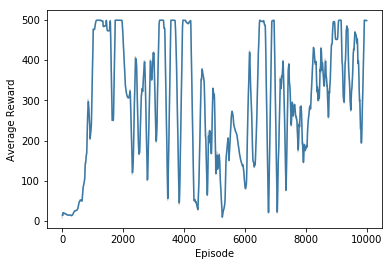

In [14]:
eps, rews = np.array(average_rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average Reward')

Text(0, 0.5, 'Total Reward')

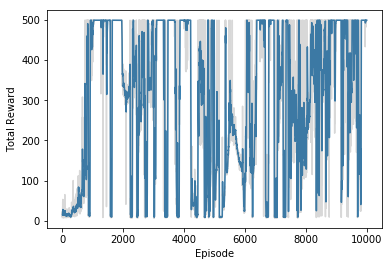

In [15]:
eps, rews = np.array(total_rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

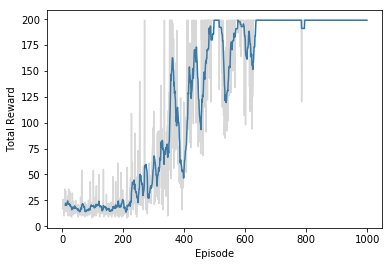

In [181]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [183]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

In [184]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.